Grover's Search Algorithm

In [27]:
import numpy as np
import math
import scipy
import cirq
import random
import matplotlib.pyplot as plt

import warnings


Part 1: Defining the size of the problem 
- set number of possible choices, then set the correct choice to 2, which would be the numver we're searching for
- determine how many qubits are needed in Grover's Algorithm for the number of choices we entered.
- Create a function that creates a binary representation of the number_choices entered. This binary representation will then be encoded into the corresponding quantum state
- Utilize the function to then generate a list named "ls" that contains the binary represenation of each of the number choices specified.  


In [10]:
number_choices = 4
correct_choice = 2

In [11]:
"Get qubits to use in the circuit for Grover's algorithm."
nqubits = 2

In [12]:
def generate_binary_strings(number_choices):
    n = int(math.log(number_choices,2))
    binary_strings = []
    for i in range(2**n):
        binary_string = bin(i)[2:].zfill(n)
        binary_strings.append(binary_string)
    return binary_strings

In [13]:
ls = generate_binary_strings(number_choices)

ls

['00', '01', '10', '11']

Part 2: Setting up the Grover Problem - we will be creating an oracle that sets the marked item
- creating the oracle (check notes in code for deeper explanations)
- creating the Grover iteration function that appends "reps" or repetitions of the oracle and the diffuser to the circuit
- initialize two qubit registers - qubits: a LineQubit of the size nqubits, and ancilla, a NamedQubit with the name "Ancilla"
- create get_marked_bitstring function to prepare a state `marked_bitstring` which converts our choice to a list of bits denoting the binary representation of the number choice. Then, print `marked_bitstring`.
- Create the circuit for Grover's Algorithm
- print the circuit


In [14]:
def make_oracle(qubits, ancilla, marked_bitstring):
    """Implements the function {f(x) = 1 if x == x', f(x) = 0 if x != x'}."""
    # For x' = (1, 1), the oracle is just a Toffoli gate.
    # For a general x', we negate the zero bits and implement a Toffoli.

    # Negate zero bits, if necessary.
    for (q, bit) in zip(qubits, marked_bitstring):
        if not bit:
            yield (cirq.X(q))
    # Do the Toffoli. change this to MCX for a generalized oracle
    #yield (cirq.TOFFOLI(qubits[0], qubits[1], ancilla))
    # controls = len(qubits) -1
    controls = len(qubits)
    mcx_gate = cirq.ControlledGate(sub_gate=cirq.X, num_controls=controls)
    yield (mcx_gate(*qubits, ancilla))

    # Negate zero bits, if necessary.
    for (q, bit) in zip(qubits, marked_bitstring):
        if not bit:
            yield (cirq.X(q))

In [15]:
def grover_iteration(qubits, ancilla, marked_bitstring, reps=1):
    """Performs one round of the Grover iteration."""
    circuit = cirq.Circuit()

    # Create an equal superposition over input qubits.
    circuit.append(cirq.H.on_each(*qubits))

    # Put the output qubit in the |-⟩ state.
    circuit.append([cirq.X(ancilla), cirq.H(ancilla)])
    for r in range(reps):
        # Query the oracle.
        # circuit.append(oracle)
        for (q, bit) in zip(qubits, marked_bitstring):
            if not bit:
                circuit.append([cirq.X(q)])
        # Do the Toffoli. change this to MCX for a generalized oracle
        #yield (cirq.TOFFOLI(qubits[0], qubits[1], ancilla))
        # controls = len(qubits) -1
        controls = len(qubits)
        mcx_gate = cirq.ControlledGate(sub_gate=cirq.X, num_controls=controls)
        circuit.append([mcx_gate(*qubits, ancilla)])

        # Negate zero bits, if necessary.
        for (q, bit) in zip(qubits, marked_bitstring):
            if not bit:
                circuit.append([cirq.X(q)])

        # Construct Grover operator.
        circuit.append(cirq.H.on_each(*qubits))
        circuit.append(cirq.X.on_each(*qubits))

        # circuit.append(cirq.H.on(qubits[-1]))
        controls = len(qubits)
        mcx_gate = cirq.ControlledGate(sub_gate=cirq.X, num_controls=controls)
        mcx_op = mcx_gate(*qubits, ancilla)
        circuit.append(mcx_op)
        # circuit.append(cirq.H.on(qubits[-1]))

        circuit.append(cirq.X.on_each(*qubits))
        circuit.append(cirq.H.on_each(*qubits))

    # Measure the input register.
    circuit.append(cirq.measure(*qubits, key="result"))

    return circuit

In [16]:
# Get qubit registers.
qubits = cirq.LineQubit.range(nqubits)
ancilla = cirq.NamedQubit("Ancilla")

In [17]:
def get_marked_bitstring(correct_choice, nqubits):
    binary_representation = list(bin(correct_choice)[2:])
    marked_bitstring = [eval(i) for i in binary_representation]
    desired_length = nqubits
    marked_bitstring = [0] * (desired_length - len(marked_bitstring)) + marked_bitstring
    return marked_bitstring

marked_bitstring = get_marked_bitstring(correct_choice, nqubits)

In [18]:
print(marked_bitstring)

[1, 0]


In [19]:
"""Create the circuit for Grover's algorithm."""
# Make oracle (black box)
oracle = make_oracle(qubits, ancilla, marked_bitstring)

# Embed the oracle into a quantum circuit implementing Grover's algorithm.
circuit = grover_iteration(qubits, ancilla, marked_bitstring, 2)


In [20]:
print("Circuit for Grover's algorithm:")
print(circuit)

Circuit for Grover's algorithm:
0: ─────────H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('result')───
                    │               │               │               │           │
1: ─────────H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M─────────────
                    │               │               │               │
Ancilla: ───X───H───X───────────────X───────────────X───────────────X─────────────────────────


part 3: Visualising the Results of Grover's Algorithm - In the final part of implementing Grover's Algorithm, we will extract the results from running the algorithm and plot the results. The results will be shown in the form of the measurement probabilities of all the different choices.
- Wrote code to then see the first measurement results
- Visualize measurement outcomes you get with zero grover iterations on a histogram. Do the results make sense?
- visualize the results for Grover's algorithm on this problem for 0 to 3 iterations. For each number of iterations, notice the histogram. What changes do you observe? Do you see amplitude amplification? Does the right choice's amplitude get amplified?


In [21]:
"""Simulate the circuit for Grover's algorithm and check the output."""
# Helper function.
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

def binary_labels(num_qubits):
    return [bin(x)[2:].zfill(num_qubits) for x in range(2 ** num_qubits)]

# Sample from the circuit a couple times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions = 1024)

# Look at the sampled bitstrings.
frequencies = result.histogram(key="result", fold_func=bitstring)
print('Sampled results:\n{}'.format(frequencies))

# Check if we actually found the secret value.
most_common_bitstring = frequencies.most_common(1)[0][0]
print("\nMost common bitstring: {}".format(most_common_bitstring))
print("Found a match? {}".format(most_common_bitstring == bitstring(marked_bitstring)))

Sampled results:
Counter({'00': 303, '01': 265, '11': 251, '10': 205})

Most common bitstring: 00
Found a match? False


Circuit for Grover's algorithm:
0: ─────────H───M('result')───
                │
1: ─────────H───M─────────────

Ancilla: ───X───H─────────────


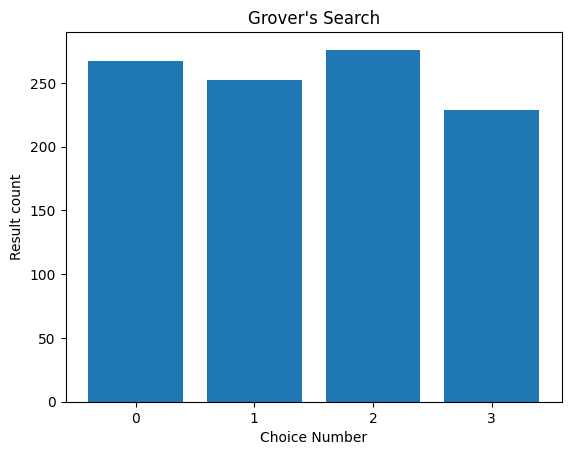

In [22]:
"""Create the circuit for Grover's algorithm."""

# Embed the oracle into a quantum circuit implementing Grover's algorithm.
circuit = grover_iteration(qubits, ancilla, marked_bitstring, 0)
print("Circuit for Grover's algorithm:")
print(circuit)
# Sample from the circuit a couple times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions = 1024)

_ = cirq.plot_state_histogram(result, plt.subplot(), title = 'Grover\'s Search', xlabel = 'Choice Number', ylabel = 'Result count', tick_label=range(2**nqubits))
plt.show()

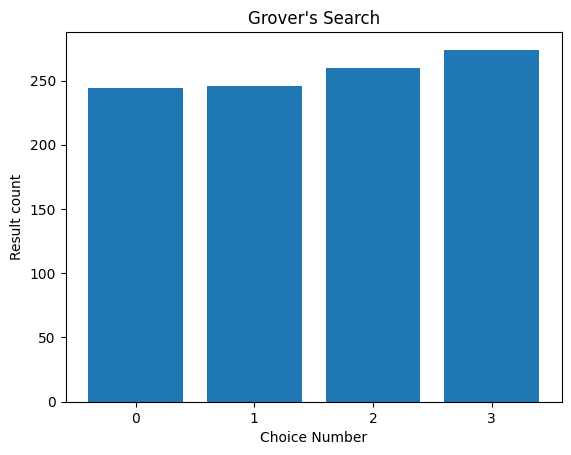

In [23]:
circuit =  grover_iteration(qubits, ancilla, marked_bitstring, 0)

simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1024)

_ = cirq.plot_state_histogram(result, plt.subplot(), title = 'Grover\'s Search', xlabel = 'Choice Number', ylabel = 'Result count', tick_label=range(2**nqubits))
plt.show()

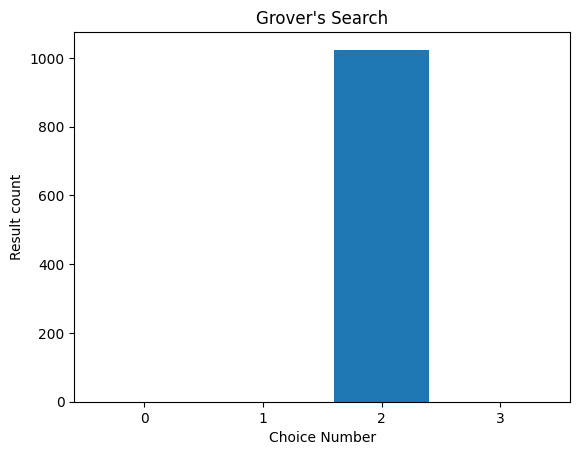

In [24]:
"""Create the circuit for Grover's algorithm."""
# Embed the oracle into a quantum circuit implementing Grover's algorithm.
circuit = grover_iteration(qubits, ancilla, marked_bitstring, 1)

# Sample from the circuit a couple times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions = 1024)

_ = cirq.plot_state_histogram(result, plt.subplot(), title = 'Grover\'s Search', xlabel = 'Choice Number', ylabel = 'Result count', tick_label=range(2**nqubits))
plt.show()

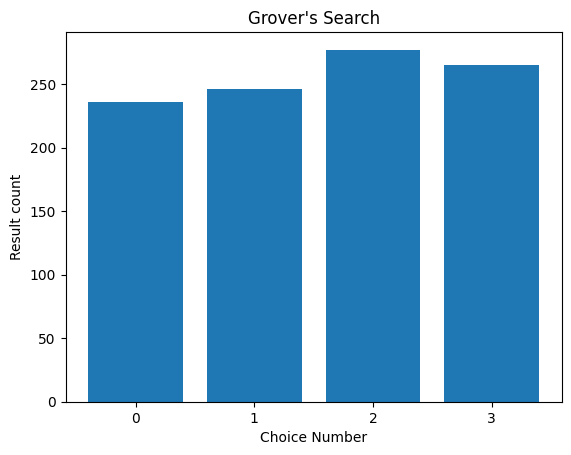

In [25]:
"""Create the circuit for Grover's algorithm."""
# Embed the oracle into a quantum circuit implementing Grover's algorithm.
circuit = grover_iteration(qubits, ancilla, marked_bitstring, 2)

# Sample from the circuit a couple times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions = 1024)

_ = cirq.plot_state_histogram(result, plt.subplot(), title = 'Grover\'s Search', xlabel = 'Choice Number', ylabel = 'Result count', tick_label=range(2**nqubits))
plt.show()

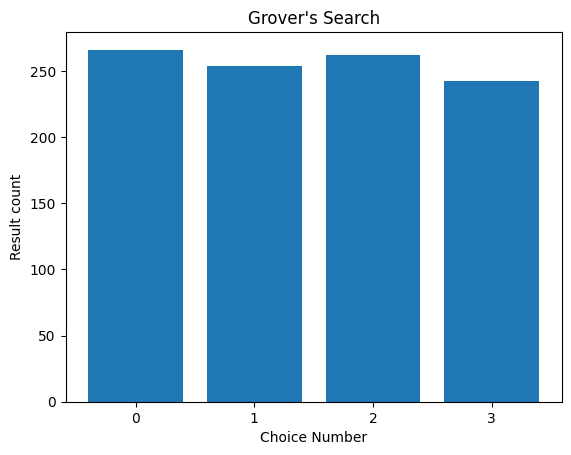

In [26]:
"""Create the circuit for Grover's algorithm."""
# Embed the oracle into a quantum circuit implementing Grover's algorithm.
circuit = grover_iteration(qubits, ancilla, marked_bitstring, 3)

# Sample from the circuit a couple times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions = 1024)

_ = cirq.plot_state_histogram(result, plt.subplot(), title = 'Grover\'s Search', xlabel = 'Choice Number', ylabel = 'Result count', tick_label=range(2**nqubits))
plt.show()

It seems like 1 grover iteration does the trick. Yay! 